In [1]:
import pandas as pd
from Bio import AlignIO
import os
import matplotlib.pyplot as plt

In [2]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower()

In [3]:
path = '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/'

In [4]:
align = AlignIO.read(open('../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/P00519_clustalO_fullidentity_all.fasta.aln'), format= 'fasta')

# Distribution seqs/MSA

In [5]:
len(align) # hacer una distribucion

104

In [6]:
# iterate over the MSA files
seqs_msa = {}
l = []
no_errors = 0
i = 0
for filename in os.listdir(path):
    f = os.path.join(path, filename) # is the complete path to each msa

    if os.path.isfile(f):
        
        # Check if file is empty
        check_file = os.stat(f).st_size
        if check_file != 0:
            msa_name = filename.split(".")[0].split("_")
            msa_name = msa_name[0] + "_" + msa_name[3]
            # align objects can be treated as lists of SeqRecord objects
            align = AlignIO.read(open(f), format= 'fasta')
            for record in align:
                try:
                    l.append([msa_name, record.id, len(record)])
                    #print("%s %i" % (record.id, len(record)))
                    seqs_msa[msa_name] = len(align)
                    i += 1
                except:
                    print(f"error in file {filename}")
                    no_errors += 1

In [7]:
i

42148

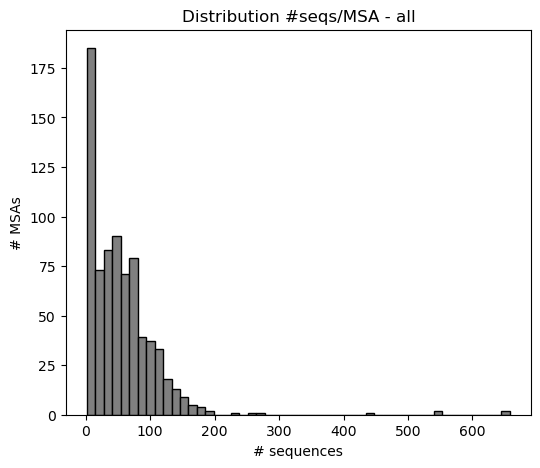

In [8]:
plt.figure(figsize=(6, 5))
plt.hist(seqs_msa.values(), bins= 50, color= 'gray', edgecolor= 'black')
plt.title("Distribution #seqs/MSA - all")
plt.ylabel("# MSAs")
plt.xlabel('# sequences')
plt.show()

<AxesSubplot:>

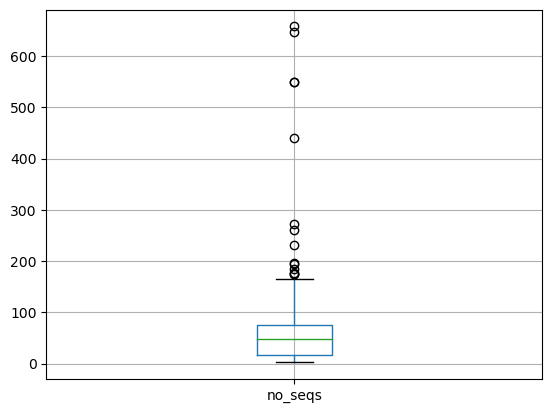

In [9]:
df= pd.DataFrame.from_dict(seqs_msa, orient= 'index').reset_index().rename(columns= {'index': 'msa', 0: 'no_seqs'})
df.boxplot()

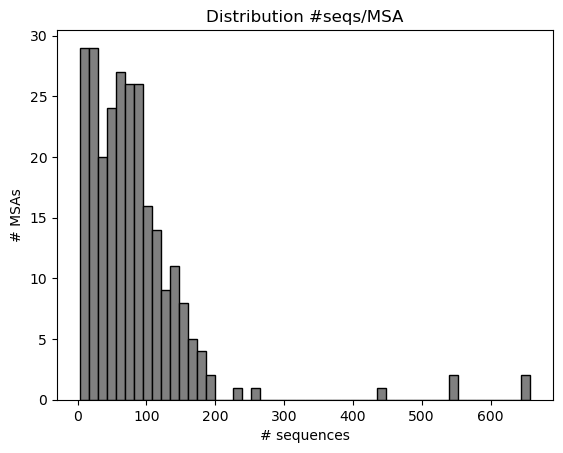

In [10]:
df[df.msa.str.endswith("all")].no_seqs.plot(kind= 'hist', bins= 50, color= 'gray', edgecolor= 'black')
plt.title("Distribution #seqs/MSA")
plt.ylabel("# MSAs")
plt.xlabel('# sequences')
plt.show()

# Orthologs overlap

In [11]:
all_msas = pd.DataFrame(l, columns= ['msa', 'uniprot', 'length_msa'])
all_msas

,msa,uniprot,length_msa
0,O49717_all,O49717,597
1,O49717_all,A0A0D3A511,597
2,O49717_all,A0A364KUL0,597
3,O49717_all,D7MEB5,597
4,O49717_all,M4DAR5,597
...,...,...,...
42143,Q9NJU9_80,A0A0L7M6Y1,563
42144,Q9FMP5_80,Q9FMP5,586
42145,Q9FMP5_80,A0A087G6J2,586
42146,Q9FMP5_80,M4E3L4,586


In [48]:
# Subset the MSAs
all = all_msas[all_msas.msa.str.endswith("all")]
msa_60 = all_msas[all_msas.msa.str.endswith("60")]
msa_80 = all_msas[all_msas.msa.str.endswith("80")]

In [14]:
# list with kinases reference proteins
kin = kinases.uniprot.unique().tolist()

In [15]:
# Create sets with unique proteins in each msa
all = all.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
all

,msa,uniprot
0,A0A2I0BVG8_all,"[A0A2I0BVG8, A0A023B173, A0A0C2IKB7, A0A0D9QJY..."
1,A0A509AFG4_all,"[A0A509AFG4, A0A015KQ67, A0A059J0T9, A0A0D9QSD..."
2,A0A509AHB6_all,"[A0A509AHB6, A0A023B173, A0A0C2IKB7, A0A0D2VHA..."
3,A0A509AKL0_all,"[A0A509AKL0, A0A023B252, A0A061DD08, A0A068Y9V..."
4,A0A509AQE6_all,"[A0A509AQE6, A0A015K587, A0A023BCV0, A0A061DD0..."
...,...,...
252,Q9ZSA3_all,"[Q9ZSA3, A0A087GM80, B6EP77, G8JN52, K5BI95, M..."
253,Q9ZSA4_all,"[Q9ZSA4, A0A0L8ICP1, A0A668RKR5, A3DEI9, C4Y9R..."
254,Q9ZUZ2_all,"[Q9ZUZ2, A0A059C0N6, A0A061CZ84, A0A061DU80, A..."
255,Q9ZV15_all,"[Q9ZV15, A0A059DJ09, A0A068UQL6, A0A087H3U3, A..."


In [16]:
all["overlap"] = [ [] for _ in range(len(all))]

In [53]:
def find_overlaps(df, refers):
    '''
    df: dataframe containing MSAs and list of proteins in each one
    refers: list containing reference proteins for checking overlap
    '''
    # Create lists with proteins in each msa
    df = df.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
    df["overlap"] = [ [] for _ in range(len(df))]
    for ix in df.index:
        lst = df.uniprot[ix][1:] # exclude the first because is the reference
        for kinase in refers:
            if kinase in lst:
                df["overlap"][ix].append(kinase)
    return df

In [55]:
msa_60_overlap = find_overlaps(msa_60, refers= kin)

In [20]:
all.sort_values('overlap')

,msa,uniprot,overlap
0,A0A2I0BVG8_all,"[A0A2I0BVG8, A0A023B173, A0A0C2IKB7, A0A0D9QJY...",[]
154,Q5BP74_all,"[Q5BP74, A0A089YRM8, A0A090LAD3, A0A096NTN2, A...",[]
155,Q5EG47_all,"[Q5EG47, A0A059ADK8, A0A068U3T4, A0A087YBI1, A...",[]
156,Q5RC72_all,"[Q5RC72, A0A096NTN2, A0A0D9S4V6, A0A1D5NXQ4, A...",[]
157,Q5VQQ5_all,"[Q5VQQ5, A0A059ACG8, A0A061GUM0, A0A068VI97, A...",[]
...,...,...,...
196,Q8BW96_all,"[Q8BW96, A0A087Y4D1, A0A087Y6B4, A0A096P3F8, A...",[Q8IU85]
208,Q8VBY2_all,"[Q8VBY2, A0A015KQK9, A0A068UG07, A0A087XW77, A...",[Q8N5S9]
206,Q8N5S9_all,"[Q8N5S9, A0A015KQK9, A0A023B173, A0A068UG07, A...",[Q8VBY2]
11,A8X6H4_all,"[A8X6H4, A0A017SN15, A0A024TW69, A0A026WPW6, A...",[Q9TXJ0]


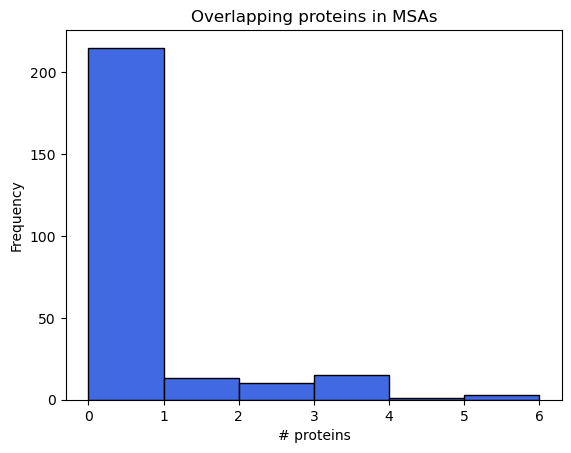

In [39]:
all.overlap.apply(lambda x: len(x)).plot(
    kind= 'hist',
    color= 'royalblue',
    edgecolor= 'black',
    bins= 6
)
plt.title("Overlapping proteins in MSAs")
plt.xlabel("# proteins")
plt.show()

In [83]:
all.groupby("msa").size()

msa
A0A2I0BVG8_all    45
A0A509AFG4_all    43
A0A509AHB6_all    28
A0A509AKL0_all    75
A0A509AQE6_all    28
                  ..
Q9ZSA3_all         7
Q9ZSA4_all         8
Q9ZUZ2_all        44
Q9ZV15_all        77
W7JX98_all        61
Length: 257, dtype: int64

### select one msa for gap strip and seq2logo

In [26]:
all_msas

,msa,uniprot,length_msa
0,O49717_all,O49717,597
1,O49717_all,A0A0D3A511,597
2,O49717_all,A0A364KUL0,597
3,O49717_all,D7MEB5,597
4,O49717_all,M4DAR5,597
...,...,...,...
42143,Q9NJU9_80,A0A0L7M6Y1,563
42144,Q9FMP5_80,Q9FMP5,586
42145,Q9FMP5_80,A0A087G6J2,586
42146,Q9FMP5_80,M4E3L4,586


# Mapping PDBs to orthologs 

In [2]:
sift = pd.read_csv(
    '../datasets/uniprot_segments_observed.tsv.gz',
    sep= '\t',
    compression= 'gzip',
    skiprows= 1
)
sift.columns = sift.columns.str.lower()

In [3]:
# Mapping: pdbs for each uniprot
pdb_uniprot = sift[['pdb', 'sp_primary']].drop_duplicates().rename(columns= {'sp_primary': 'uniprot_acc'})
pdb_uniprot

,pdb,uniprot_acc
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [17]:
# Get list of orthologs
ortho = all_msas.uniprot.unique().tolist()

In [20]:
len(ortho)

13652

In [19]:
pdb_uniprot[pdb_uniprot.uniprot_acc.isin(ortho)]

,pdb,uniprot_acc
965,1gag,P06213
1044,1gzo,P31751
1234,1i35,P28829
1237,1i44,P06213
1986,1m17,P00533
...,...,...
976383,7urz,Q13554
976469,7pg4,P06213
976493,7pg3,P06213
977452,7up8,O75582


### df with regions (KDs and CREs)

In [30]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower().str.replace(" ", "_")
kinases = kinases.rename(columns= {'uniprot': 'uniprot_acc', 'cre_(start)': 'cre_start', 'cre_(end)': 'cre_end', 'kd_(start)': 'kd_start', 'kd_(end)': 'kd_end'})
kinases

,uniprot_acc,organism,cre_start,cre_end,cre_(s_or_d),length,kd_start,kd_end,pdb_id,pdb_res_(å),af,status
0,A0A2I0BVG8,P. falciparum (isolate NF54),346,353,no,NaN,56,325,no,no,AF-A0A2I0BVG8-F1,new
1,A0A509AFG4,P. berghei (strain Anka),385,393,no,NaN,110,365,no,no,AF-A0A509AFG4-F1,new
2,A0A509AHB6,P. berghei (strain Anka),345,352,no,NaN,57,324,no,no,AF-A0A509AHB6-F1,new
3,A0A509AKL0,P. berghei (strain Anka),1,33,no,NaN,545,802,no,no,AF-A0A509AKL0-F1,new
4,A0A509AQE6,P. berghei (strain Anka),394,402,no,NaN,118,372,no,no,AF-A0A509AQE6-F1,new
...,...,...,...,...,...,...,...,...,...,...,...,...
297,Q9ZSA4,A. thaliana,295,325,no,NaN,28,290,no,no,AF-Q9ZSA4-F1,new
298,Q9ZUZ2,A. thaliana,409,439,no,NaN,143,405,no,no,AF-Q9ZUZ2-F1,new
299,Q9ZV15,A. thaliana,398,428,no,NaN,134,392,no,no,AF-Q9ZV15-F1,new
300,W0LYS5,M. nipponense,287,327,no,NaN,31,287,no,no,AF-W0LYS5-F1,new


In [56]:
kd = kinases[['uniprot_acc', 'kd_start', 'kd_end']].drop_duplicates().rename(
    columns= {
        'kd_start': 'start',
        'kd_end': 'end'
    }
)
ids = [ "kd" + str(i) for i in range(1, len(kd)+1) ]
kd['term_id'] = ids

In [58]:
#kd.to_csv('../datasets/kd.tsv', sep= '\t', index= False)

In [59]:
kd

,uniprot_acc,start,end,term_id
0,A0A2I0BVG8,56,325,kd1
1,A0A509AFG4,110,365,kd2
2,A0A509AHB6,57,324,kd3
3,A0A509AKL0,545,802,kd4
4,A0A509AQE6,118,372,kd5
...,...,...,...,...
297,Q9ZSA4,28,290,kd282
298,Q9ZUZ2,143,405,kd283
299,Q9ZV15,134,392,kd284
300,W0LYS5,31,287,kd285


In [60]:
cre = kinases[['uniprot_acc', 'cre_start', 'cre_end']].drop_duplicates().rename(
    columns= {
        'cre_start': 'start',
        'cre_end': 'end'
    }
)
ids = [ "cre" + str(i) for i in range(1, len(cre)+1) ]
cre['term_id'] = ids

In [64]:
#cre.to_csv('../datasets/cre.tsv', sep= '\t', index= False)

In [66]:
regions = pd.concat([kd, cre], ignore_index= True)

In [68]:
#regions.to_csv('../datasets/regions.txt', sep= '\t', index= True)